In [1]:
# Run preprocessing script to make dataframe objects available.

%run PreProcessing.ipynb

Current Progress: 100.0 %


In [2]:
# Import required libraries.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from dtreeviz.trees import dtreeviz
from mlxtend.evaluate import bias_variance_decomp

In [3]:
# Assign 'X' and 'y' values and split into seperate train and test df.
# If there is little benefit from specific indicators they can be removed.

X = summary_data_avg[['pp2m2', 'heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']]
y = summary_data_avg['mean_diameter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
X_train.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
1239,35,1297,891485,29.7,8.0,57.0,35.0,Drilled,Nun 70406,Conventional,Barley
1714,33,622,951847,43.7,13.0,55.0,32.0,Blocks,Krypton,Conventional,Fleece
1555,34,710,841765,25.8,32.0,51.0,17.0,Blocks,Linkton,Conventional,Fleece
2645,30,2086,1537966,2.9,38.0,49.0,13.0,Drilled,Chiefton,Conventional,None
891,45,1033,899669,39.1,47.0,29.0,24.0,Drilled,Linkton,Conventional,Barley


In [4]:
X_test.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
3314,36,1091,653896,2.6,57.0,28.0,15.0,Plant Tape,Chiefton,Conventional,None
118,42,1479,1300944,32.8,27.0,45.0,28.0,Drilled,Longton,Conventional,Barley
3169,25,1620,895582,2.6,57.0,28.0,15.0,Plant Tape,Chiefton,Conventional,None
2624,30,2656,2126672,2.9,38.0,49.0,13.0,Drilled,Triton,Conventional,None
2927,29,2281,1599232,26.7,22.0,55.0,23.0,Drilled,Chiefton,Conventional,Barley


In [5]:
# Encode categoriccal variables that will be used as predictors
# Error message appearing but code seems to work.

enc = OrdinalEncoder()

pd.options.mode.chained_assignment = None  # default='warn'

encoded_array = enc.fit_transform(X_train[['method', 'variety', 'inputs', 'protection']])
X_train.loc[:, ['method', 'variety', 'inputs', 'protection']] = encoded_array.copy()

encoded_array = enc.transform(X_test[['method', 'variety', 'inputs', 'protection']])
X_test.loc[:, ['method', 'variety', 'inputs', 'protection']] = encoded_array.copy()


In [6]:
type(encoded_array)

numpy.ndarray

In [7]:
X_train.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
1239,35,1297,891485,29.7,8.0,57.0,35.0,2.0,18.0,1.0,0.0
1714,33,622,951847,43.7,13.0,55.0,32.0,1.0,11.0,1.0,1.0
1555,34,710,841765,25.8,32.0,51.0,17.0,1.0,16.0,1.0,1.0
2645,30,2086,1537966,2.9,38.0,49.0,13.0,2.0,4.0,1.0,2.0
891,45,1033,899669,39.1,47.0,29.0,24.0,2.0,16.0,1.0,0.0


In [8]:
X_test.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection
3314,36,1091,653896,2.6,57.0,28.0,15.0,4.0,4.0,1.0,2.0
118,42,1479,1300944,32.8,27.0,45.0,28.0,2.0,17.0,1.0,0.0
3169,25,1620,895582,2.6,57.0,28.0,15.0,4.0,4.0,1.0,2.0
2624,30,2656,2126672,2.9,38.0,49.0,13.0,2.0,26.0,1.0,2.0
2927,29,2281,1599232,26.7,22.0,55.0,23.0,2.0,4.0,1.0,0.0


In [9]:
print(max(X_train['method']))
print(max(X_train['inputs']))
print(max(X_train['variety']))
print(max(X_train['protection']))

5.0
2.0
26.0
3.0


In [10]:
# Use the isolation forest algorithm to remove the most rogue 5% of datapoints.

print(f"The old training dataframe shape: {X_train.shape}")

clf1 = IsolationForest(max_samples=500, random_state = 10, contamination = 0.05)
preds = clf1.fit_predict(X_train)

totalOutliers=0
for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
print("Total number of outliers identified is: ",totalOutliers)

The old training dataframe shape: (2804, 11)


C:\Users\tmccl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Total number of outliers identified is:  141


In [11]:
# Remove outliers from training data.
# Do not remove from test data as this is bad practice.
# Confirm removal by checking new df shape.

filtered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
  else:
    filtered_array.append(False)
X_train = X_train[filtered_array]
y_train = y_train[filtered_array]

print(f"The new training dataframe shape: {X_train.shape}")

The new training dataframe shape: (2663, 11)


In [12]:
X_train['protection'].value_counts()

0.0    1305
2.0    1204
1.0     131
3.0      23
Name: protection, dtype: int64

In [13]:
# Scaled data although there is no need to scale with a Random Forest algorithm.
# Only fit the scaled data using the training df but use it to transform both test and train.
# This data won't be used but this is necessary for a lot of other ML algorithms.
# Keep here as a reminder in case another model is developed.

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [14]:
# Hypertuning model to find best parameters.
# Print the best qualitative parameters to use within the model.

param_grid = {'random_state': [10],
              'max_features': ['sqrt', 'auto', 'log2'],
              'bootstrap': [True, False]}  
   
grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3, n_jobs= 2)

grid_rfr.fit(X_train, y_train) 
 
print(grid_rfr.best_params_)   

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'bootstrap': False, 'max_features': 'sqrt', 'random_state': 10}


In [15]:
# Fit semi-hypertuned model and print score.

rfr = RandomForestRegressor(bootstrap = False,
                            max_features = 'sqrt',
                            random_state = 10)

rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.9375628265270713


In [34]:
def hypertune_eval(param, seq_min, seq_max, seq_int, model):
    
    sequence = np.arange(seq_min, seq_max, seq_int)
    acc = []
    bias = []
    var = []
    mse = []
    
    for n in sequence:
        model.set_params(**{param : n})
        model.fit(X_train, y_train)
        acc.append(model.score(X_test, y_test))
        mse_decomp, bias_decomp, var_decomp = bias_variance_decomp(model, X_train.values, y_train.values, X_test.values, y_test.values, loss= 'mse', num_rounds = 10, random_seed = 1)
        bias.append(bias_decomp)
        var.append(var_decomp)
        mse.append(mse_decomp)
        
        
    fig, axs = plt.subplots(2, 2, figsize=(8, 5), constrained_layout=True, sharex=True)
    
    fig.suptitle(f'Effect of Changing {param} Parameter')
    fig.supxlabel(f'{param}')
    
    axs[0,0].plot(sequence, acc)
    axs[0,0].set_ylabel('accuracy')
    
    axs[0,1].plot(sequence, mse)
    axs[0,1].set_ylabel('mean squared error')
    
    axs[1,0].plot(sequence, bias)
    axs[1,0].set_ylabel('bias')
    
    axs[1,1].plot(sequence, var)
    axs[1,1].set_ylabel('variance')
        

14
14
14
14


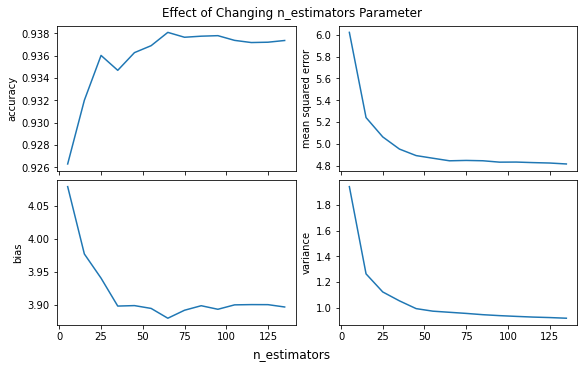

In [32]:
# Optimisation of n_estimators parameter.

hypertune_eval('n_estimators', 5, 145, 10, rfr)

In [17]:
# Set parameter to optimum.

rfr.set_params(n_estimators = 40)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.930812720023402


9
9
9
9


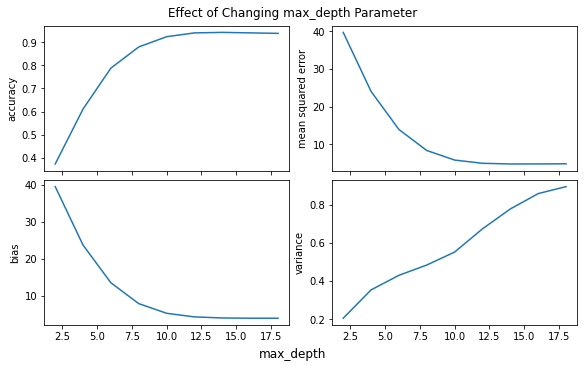

In [33]:
# Optimisation for max_depth parameter.

hypertune_eval('max_depth', 2, 20, 2, rfr)

In [35]:
# Set parameter to optimum and retest score.

rfr.set_params(max_depth = 12)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.9399592437771129


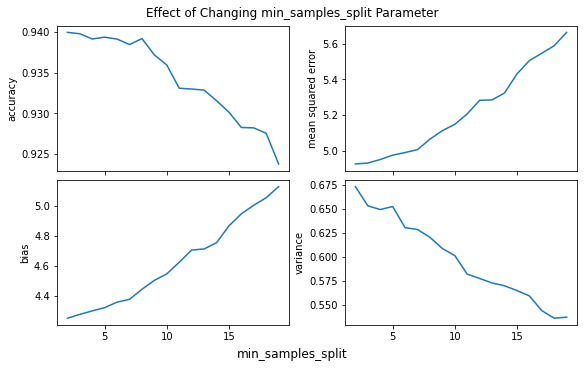

In [36]:
# Optimisation for min_samples_split parameter.

hypertune_eval('min_samples_split', 2, 20, 2, rfr)

In [37]:
# Set parameter to optimum and retest score.

rfr.set_params(min_samples_split = 10)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

0.9359355484880565


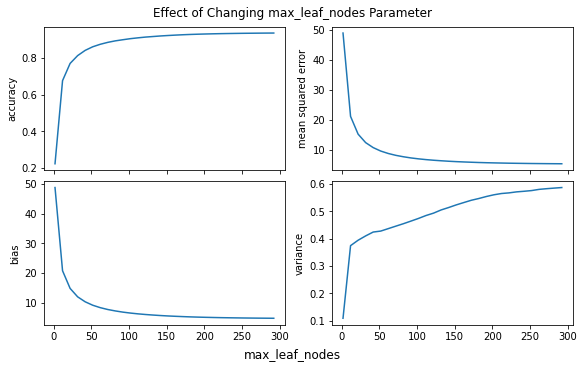

In [38]:
# Optimisation for max_leaf_nodes parameter.

hypertune_eval('max_leaf_nodes', 2, 252, 10, rfr)

In [39]:
# Set parameter to optimum and retest score.

rfr.set_params(max_leaf_nodes = 150)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

rfr_pred = rfr.predict(X_test)

0.9217234216883747


In [40]:
# Join 'X' and 'y' test df together along with predictions to make visualisations easier.
# Please note... only the test data.

y_test_df = y_test.to_frame()
y_test_df = y_test_df.rename(columns = {0:'mean_diameter'}).reset_index(drop=True)

pred_df = pd.DataFrame(rfr_pred, columns = ['predicted_mean_diameter']).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test, columns = ['pp2m2', 'heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']).reset_index(drop = True)

test_df = X_test_df.copy()
test_df['predicted_mean_diameter'] = pd.Series(pred_df['predicted_mean_diameter'])
test_df['mean_diameter'] = pd.Series(y_test_df['mean_diameter'])

test_df[['method', 'variety', 'inputs', 'protection']] = enc.inverse_transform(test_df[['method',
                                                                                        'variety',
                                                                                        'inputs',
                                                                                        'protection']])

test_df.head()

,pp2m2,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection,predicted_mean_diameter,mean_diameter
0,36,1091,653896,2.6,57.0,28.0,15.0,Plant Tape,Chiefton,Conventional,None,13.617600,10.017778
1,42,1479,1300944,32.8,27.0,45.0,28.0,Drilled,Longton,Conventional,Barley,10.625938,7.666667
2,25,1620,895582,2.6,57.0,28.0,15.0,Plant Tape,Chiefton,Conventional,None,25.497065,26.643200
3,30,2656,2126672,2.9,38.0,49.0,13.0,Drilled,Triton,Conventional,None,26.471821,26.250667
4,29,2281,1599232,26.7,22.0,55.0,23.0,Drilled,Chiefton,Conventional,Barley,22.166183,20.208276


In [41]:
test_df.shape

(701, 13)

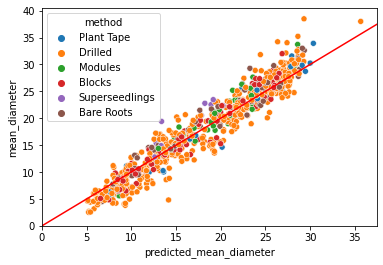

In [42]:
# Scatterplot to show how predicted mean compares to actual mean.
# Set hue to see if any indicator variables have a bias.

sns.scatterplot(y = 'mean_diameter', x = 'predicted_mean_diameter', hue = 'method', data = test_df)
plt.axline([0, 0], [1, 1], color = 'r')
plt.ylim(0)
plt.xlim(0)
plt.show()

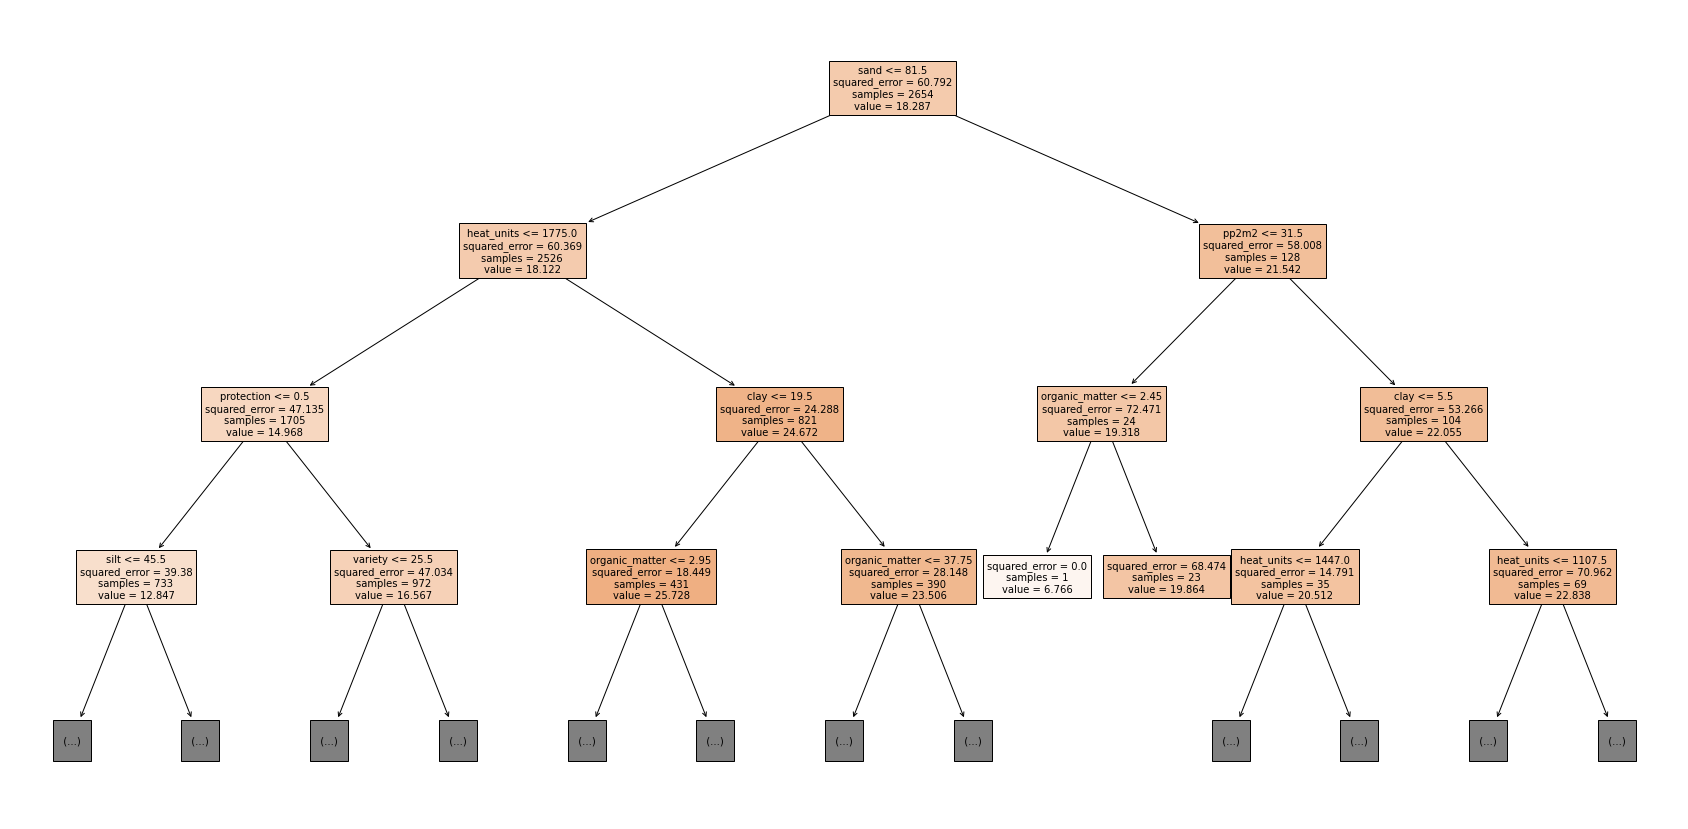

In [27]:
# Tree visualisation to depth of 3.
# Struggling to make visualisation go any deeper.

plt.figure(figsize=(30,15))
tree.plot_tree(rfr.estimators_[0], feature_names=X_train.columns, filled=True, max_depth = 3, fontsize=10)
plt.savefig('Decision Tree.png', dpi=300, bbox_inches = 'tight')
plt.show()

Text(0.5, 0, 'Feature Importance')

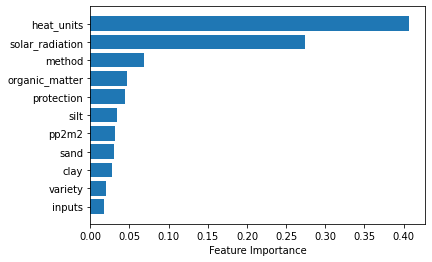

In [28]:
sort = rfr.feature_importances_.argsort()
plt.barh(np.array(X_test.columns)[sort], rfr.feature_importances_[sort])
plt.xlabel("Feature Importance")